In [89]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define Functions

In [90]:
def rotate_clockwise(vx, vy, radians):
    sin = np.sin(radians)
    cos = np.cos(radians)
    new_x = vx*cos + vy*sin
    new_y = -vx*sin + vy*cos
    return np.vstack([new_x, new_y]).T

In [91]:
def fourier(values, period=None, degree=3):
    r = values
    if period is not None:
        r = values/period * 2*np.pi
    args = pd.concat([(idx+1)*r for idx in range(degree)], axis=1)
    cols = ['{}sin'.format(idx+1) for idx in range(degree)] + ['{}cos'.format(idx+1) for idx in range(degree)]
    X_df = pd.concat([np.sin(args), np.cos(args)], axis=1)
    X_df.columns = cols
    return X_df.reindex(sorted(X_df.columns), axis=1)

In [92]:
def interaction(X, Y):
    Z = np.zeros((X.shape[0], X.shape[1]*Y.shape[1]))
    for idx in range(X.shape[1]):
        i = idx*Y.shape[1]
        for jdx in range(Y.shape[1]):
            Z[:,i+jdx] = X[:,idx]*Y[:,jdx]
    return Z

## Read in Data

In [93]:
df = pd.read_csv(r'ERA5_fc_065393_20000101-20190601_no_metadata.txt', index_col='Date_Time', sep='\t')[['Wind_Spd', 'Wind_Dir']]
df.index = pd.to_datetime(df.index)
df.head()

,Wind_Spd,Wind_Dir
Date_Time,,
2000-01-01 07:00:00,9.94,175.0
2000-01-01 08:00:00,9.52,181.0
2000-01-01 09:00:00,9.31,188.0
2000-01-01 10:00:00,9.33,197.0
2000-01-01 11:00:00,9.71,210.0


In [94]:
dir_radians = df.Wind_Dir/180*np.pi
df.loc[:, 'east'] = np.sin(dir_radians)*df['Wind_Spd']
df.loc[:, 'north'] = np.cos(dir_radians)*df['Wind_Spd']
df.head()

,Wind_Spd,Wind_Dir,east,north
Date_Time,,,,
2000-01-01 07:00:00,9.94,175.0,0.866328,-9.902175
2000-01-01 08:00:00,9.52,181.0,-0.166147,-9.518550
2000-01-01 09:00:00,9.31,188.0,-1.295702,-9.219396
2000-01-01 10:00:00,9.33,197.0,-2.727828,-8.922323
2000-01-01 11:00:00,9.71,210.0,-4.855000,-8.409107


## Fit Mu

In [181]:
julian_values = pd.Series(data=df.index.to_julian_date(), index=df.index)
diurnal_fourier = fourier(julian_values, 1, degree=6).values
seasonal_fourier = fourier(julian_values, 365.25, degree=6).values
T6 = np.hstack([diurnal_fourier, seasonal_fourier, interaction(diurnal_fourier, seasonal_fourier)])
T5 = np.hstack([diurnal_fourier[:,0:10], seasonal_fourier[:,0:10], interaction(diurnal_fourier[:,0:10], seasonal_fourier[:,0:10])])
T4 = np.hstack([diurnal_fourier[:,0:8], seasonal_fourier[:,0:8], interaction(diurnal_fourier[:,0:8], seasonal_fourier[:,0:8])])
T3 = np.hstack([diurnal_fourier[:,0:6], seasonal_fourier[:,0:6], interaction(diurnal_fourier[:,0:6], seasonal_fourier[:,0:6])])
T2 = np.hstack([diurnal_fourier[:,0:4], seasonal_fourier[:,0:4], interaction(diurnal_fourier[:,0:4], seasonal_fourier[:,0:4])])

In [182]:
y = df[['east', 'north']].values 
X_mu = T6
reg_mu = linear_model.Ridge(alpha=100, fit_intercept=True)
reg_mu.fit(X_mu, y)

Ridge(alpha=100)

In [183]:
X_mu.shape

(170184, 168)

In [184]:
# predict mu
df[['east_mu', 'north_mu']] = reg_mu.predict(T6)
df[['east_resid', 'north_resid']] = df[['east', 'north']].values - df[['east_mu', 'north_mu']].values
df.head()

,Wind_Spd,Wind_Dir,east,north,east_mu,north_mu,east_resid,north_resid,east_resid_prev,north_resid_prev
Date_Time,,,,,,,,,,
2000-01-01 07:00:00,9.94,175.0,0.866328,-9.902175,-4.533230,-3.313729,5.399558,-6.588446,NaN,NaN
2000-01-01 08:00:00,9.52,181.0,-0.166147,-9.518550,-4.590891,-3.340740,4.424744,-6.177810,5.399558,-6.588446
2000-01-01 09:00:00,9.31,188.0,-1.295702,-9.219396,-4.567466,-3.371489,3.271765,-5.847907,4.424744,-6.177810
2000-01-01 10:00:00,9.33,197.0,-2.727828,-8.922323,-4.506369,-3.410048,1.778541,-5.512275,3.271765,-5.847907
2000-01-01 11:00:00,9.71,210.0,-4.855000,-8.409107,-4.487970,-3.436896,-0.367030,-4.972210,1.778541,-5.512275


<AxesSubplot:xlabel='Date_Time'>

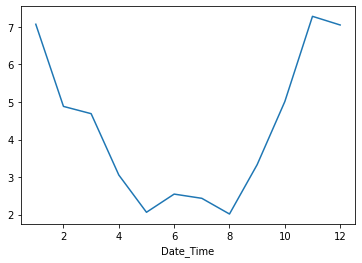

In [185]:
np.sqrt(df[['east', 'north']].groupby(df.index.month).mean()**2).sum(axis=1).plot()

<AxesSubplot:xlabel='Date_Time'>

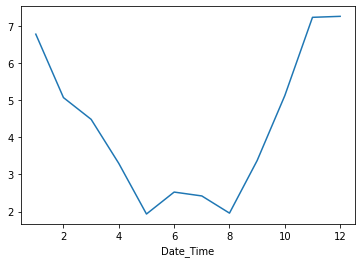

In [186]:
np.sqrt(df[['east_mu', 'north_mu']].groupby(df.index.month).mean()**2).sum(axis=1).plot()

<AxesSubplot:xlabel='Date_Time'>

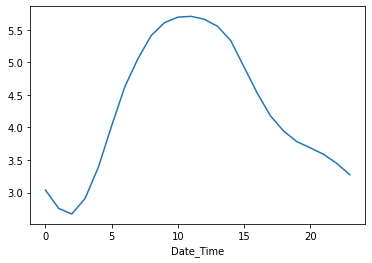

In [187]:
np.sqrt(df[['east', 'north']].groupby(df.index.hour).mean()**2).sum(axis=1).plot()

<AxesSubplot:xlabel='Date_Time'>

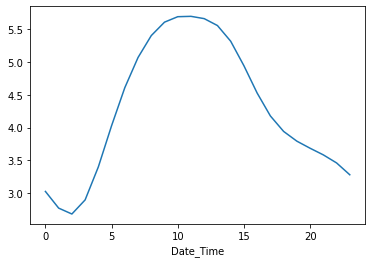

In [188]:
np.sqrt(df[['east_mu', 'north_mu']].groupby(df.index.hour).mean()**2).sum(axis=1).plot()

### prepare autocorrelation

In [189]:

df['east_resid_prev'] = df.east_resid.shift(1)
df['north_resid_prev'] = df.north_resid.shift(1)
# df['dir_prev'] = df.Wind_Dir.shift(1)
# df['spd_prev'] = df.Wind_Spd.shift(1)
df.head()

,Wind_Spd,Wind_Dir,east,north,east_mu,north_mu,east_resid,north_resid,east_resid_prev,north_resid_prev
Date_Time,,,,,,,,,,
2000-01-01 07:00:00,9.94,175.0,0.866328,-9.902175,-4.533230,-3.313729,5.399558,-6.588446,NaN,NaN
2000-01-01 08:00:00,9.52,181.0,-0.166147,-9.518550,-4.590891,-3.340740,4.424744,-6.177810,5.399558,-6.588446
2000-01-01 09:00:00,9.31,188.0,-1.295702,-9.219396,-4.567466,-3.371489,3.271765,-5.847907,4.424744,-6.177810
2000-01-01 10:00:00,9.33,197.0,-2.727828,-8.922323,-4.506369,-3.410048,1.778541,-5.512275,3.271765,-5.847907
2000-01-01 11:00:00,9.71,210.0,-4.855000,-8.409107,-4.487970,-3.436896,-0.367030,-4.972210,1.778541,-5.512275


In [190]:
df1 = df.dropna()
df1 = df1.loc[~df1.index.hour.isin([7, 19])]
# df1 = df1.loc[df1.index.month==7]
df1.head()

,Wind_Spd,Wind_Dir,east,north,east_mu,north_mu,east_resid,north_resid,east_resid_prev,north_resid_prev
Date_Time,,,,,,,,,,
2000-01-01 08:00:00,9.52,181.0,-0.166147,-9.518550,-4.590891,-3.340740,4.424744,-6.177810,5.399558,-6.588446
2000-01-01 09:00:00,9.31,188.0,-1.295702,-9.219396,-4.567466,-3.371489,3.271765,-5.847907,4.424744,-6.177810
2000-01-01 10:00:00,9.33,197.0,-2.727828,-8.922323,-4.506369,-3.410048,1.778541,-5.512275,3.271765,-5.847907
2000-01-01 11:00:00,9.71,210.0,-4.855000,-8.409107,-4.487970,-3.436896,-0.367030,-4.972210,1.778541,-5.512275
2000-01-01 12:00:00,9.83,226.0,-7.071110,-6.828492,-4.506642,-3.427788,-2.564469,-3.400703,-0.367030,-4.972210


In [191]:
df1.describe()

,Wind_Spd,Wind_Dir,east,north,east_mu,north_mu,east_resid,north_resid,east_resid_prev,north_resid_prev
count,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000
mean,6.408618,207.420931,-2.361158,-1.910784,-2.362769,-1.908187,0.001611,-0.002597,-0.001566,0.002386
std,3.239643,85.392235,4.617209,4.584876,1.407192,1.295185,4.397015,4.397635,4.394916,4.394809
min,0.020000,0.000000,-21.703777,-18.328828,-4.747917,-3.810583,-19.395228,-15.628318,-19.395228,-15.628318
25%,3.890000,158.000000,-5.779117,-5.143804,-3.717164,-2.982041,-3.169016,-3.100729,-3.171389,-3.093867
50%,6.110000,225.000000,-2.491403,-1.696551,-2.235949,-2.356590,-0.085658,0.022116,-0.099882,0.024670
75%,8.660000,266.000000,1.002835,1.393008,-1.412044,-0.764347,3.199688,3.028365,3.191148,3.029724
max,22.760000,360.000000,14.311519,15.392165,1.616399,1.202778,16.843645,18.451846,16.843645,18.451846


## Fit Resid

In [228]:
julian_values = pd.Series(data=df1.index.to_julian_date(), index=df1.index)
diurnal_fourier = fourier(julian_values, 1, degree=6).values
seasonal_fourier = fourier(julian_values, 365.25, degree=6).values
T6 = np.hstack([diurnal_fourier, seasonal_fourier, interaction(diurnal_fourier, seasonal_fourier)])

T4 = np.hstack([diurnal_fourier[:,0:8], seasonal_fourier[:,0:8], interaction(diurnal_fourier[:,0:8], seasonal_fourier[:,0:8])])
T3 = np.hstack([diurnal_fourier[:,0:6], seasonal_fourier[:,0:6], interaction(diurnal_fourier[:,0:6], seasonal_fourier[:,0:6])])
T2 = np.hstack([diurnal_fourier[:,0:4], seasonal_fourier[:,0:4], interaction(diurnal_fourier[:,0:4], seasonal_fourier[:,0:4])])

<AxesSubplot:xlabel='east_resid_prev', ylabel='east_resid'>

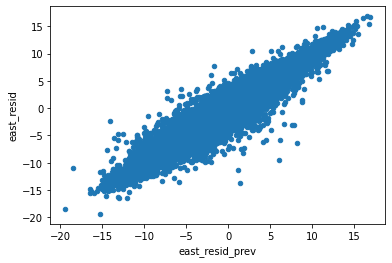

In [229]:
df1.plot(kind='scatter', x='east_resid_prev', y='east_resid')

In [230]:

linear = df1[['east_resid_prev', 'north_resid_prev']].values

y = df1[['east_resid', 'north_resid']].values 
X_resid = np.hstack([linear, interaction(linear, T6)])
reg_resid = linear_model.Ridge(alpha=1000, fit_intercept=False)
reg_resid.fit(X_resid, y)

Ridge(alpha=1000, fit_intercept=False)

In [231]:
reg_resid.intercept_

0.0

In [232]:
reg_resid.coef_.shape

(2, 338)

## Calculate Error

In [233]:
east_north_deltas = reg_resid.predict(X_resid)

In [234]:
df1[['east_pred', 'north_pred']] = df1[['east_mu', 'north_mu']].values + east_north_deltas
df1['east_error'] = df1.east - df1.east_pred
df1['north_error'] = df1.north - df1.north_pred
df1['sq_error'] = df1.east_error**2 + df1.north_error**2
df1.head()

,Wind_Spd,Wind_Dir,east,north,east_mu,north_mu,east_resid,north_resid,east_resid_prev,north_resid_prev,east_pred,north_pred,east_error,north_error,sq_error,pred_angle,dir_error2,spd_error2
Date_Time,,,,,,,,,,,,,,,,,,
2000-01-01 08:00:00,9.52,181.0,-0.166147,-9.518550,-4.590891,-3.340740,4.424744,-6.177810,5.399558,-6.588446,0.362419,-10.019320,-0.528566,0.500770,0.530153,3.100643,0.308784,0.247580
2000-01-01 09:00:00,9.31,188.0,-1.295702,-9.219396,-4.567466,-3.371489,3.271765,-5.847907,4.424744,-6.177810,-0.512243,-9.585424,-0.783458,0.366028,0.747783,-3.090967,0.684764,0.134744
2000-01-01 10:00:00,9.33,197.0,-2.727828,-8.922323,-4.506369,-3.410048,1.778541,-5.512275,3.271765,-5.847907,-1.508721,-9.303016,-1.219107,0.380693,1.631148,-2.979492,1.567695,0.054178
2000-01-01 11:00:00,9.71,210.0,-4.855000,-8.409107,-4.487970,-3.436896,-0.367030,-4.972210,1.778541,-5.512275,-2.945500,-9.013148,-1.909500,0.604041,4.011056,-2.825340,3.995743,0.000009
2000-01-01 12:00:00,9.83,226.0,-7.071110,-6.828492,-4.506642,-3.427788,-2.564469,-3.400703,-0.367030,-4.972210,-5.080523,-8.404396,-1.990588,1.575905,6.445915,-2.600934,6.491929,0.095358


In [235]:
df1['pred_angle'] = np.arctan2(df1.east_pred, df1.north_pred)

In [236]:
df1[['dir_error2', 'spd_error2']] = rotate_clockwise(df1.east_error, df1.north_error, -df1.pred_angle)**2
df1.head()

,Wind_Spd,Wind_Dir,east,north,east_mu,north_mu,east_resid,north_resid,east_resid_prev,north_resid_prev,east_pred,north_pred,east_error,north_error,sq_error,pred_angle,dir_error2,spd_error2
Date_Time,,,,,,,,,,,,,,,,,,
2000-01-01 08:00:00,9.52,181.0,-0.166147,-9.518550,-4.590891,-3.340740,4.424744,-6.177810,5.399558,-6.588446,0.362419,-10.019320,-0.528566,0.500770,0.530153,3.105436,0.260221,0.269931
2000-01-01 09:00:00,9.31,188.0,-1.295702,-9.219396,-4.567466,-3.371489,3.271765,-5.847907,4.424744,-6.177810,-0.512243,-9.585424,-0.783458,0.366028,0.747783,-3.088204,0.643003,0.104780
2000-01-01 10:00:00,9.33,197.0,-2.727828,-8.922323,-4.506369,-3.410048,1.778541,-5.512275,3.271765,-5.847907,-1.508721,-9.303016,-1.219107,0.380693,1.631148,-2.980817,1.598523,0.032625
2000-01-01 11:00:00,9.71,210.0,-4.855000,-8.409107,-4.487970,-3.436896,-0.367030,-4.972210,1.778541,-5.512275,-2.945500,-9.013148,-1.909500,0.604041,4.011056,-2.825733,4.010695,0.000361
2000-01-01 12:00:00,9.83,226.0,-7.071110,-6.828492,-4.506642,-3.427788,-2.564469,-3.400703,-0.367030,-4.972210,-5.080523,-8.404396,-1.990588,1.575905,6.445915,-2.597865,6.344251,0.101664


### Fit Residual Variance

In [237]:
sigma = np.sqrt(df1.sq_error.mean())
sigma

1.1247067010492264

In [238]:
# np.sqrt(df1.dir_error2.mean())

In [239]:
# np.sqrt(df1.spd_error2.mean())

In [240]:
# df1.dir_error2.groupby(pd.cut(df1.pred_angle, np.linspace(-np.pi, np.pi, 15))).mean().plot()

In [241]:
# df1.spd_error2.groupby(pd.cut(df1.pred_angle, np.linspace(-np.pi, np.pi, 15))).mean().plot()

In [249]:
y = df1[['dir_error2', 'spd_error2']].values
# y = df1.sq_error.values
# direction_fourier = fourier(df1.pred_angle, degree=3).values
# X_error = np.hstack([direction_fourier, T4, interaction(direction_fourier, T2)])
X_error = T6
reg_error = linear_model.Ridge(alpha=1000, fit_intercept=True)
reg_error.fit(X_error, y)

Ridge(alpha=1000)

In [250]:
reg_error.intercept_

array([0.75061567, 0.51036066])

In [251]:
reg_error.coef_.shape

(2, 168)

<AxesSubplot:xlabel='Date_Time'>

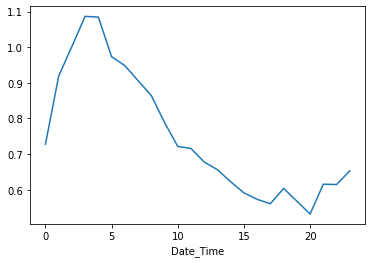

In [252]:
df1.dir_error2.groupby(df1.index.hour).mean().plot()

<AxesSubplot:xlabel='Date_Time'>

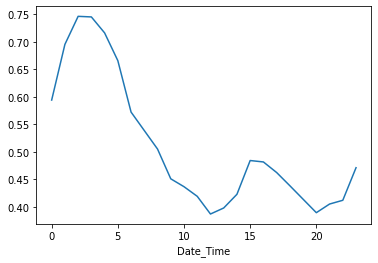

In [253]:
df1.spd_error2.groupby(df1.index.hour).mean().plot()

<AxesSubplot:xlabel='Date_Time'>

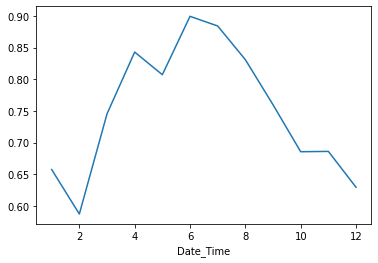

In [254]:
df1.dir_error2.groupby(df1.index.month).mean().plot()

<AxesSubplot:xlabel='Date_Time'>

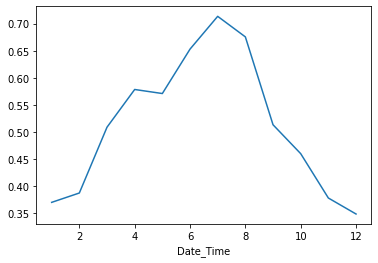

In [255]:
df1.spd_error2.groupby(df1.index.month).mean().plot()

## Generate Timeseries

In [311]:
np.random.seed(991)
# reproduce the time series
# julian_values = pd.Series(data=df1.index.to_julian_date(), index=df1.index)
# diurnal_fourier = fourier(julian_values, 1, degree=3).values
# seasonal_fourier = fourier(julian_values, 365.25, degree=3).values
# T3 = np.hstack([diurnal_fourier, seasonal_fourier, interaction(diurnal_fourier, seasonal_fourier)])
# T2 = np.hstack([diurnal_fourier[:,0:4], seasonal_fourier[:,0:4], interaction(diurnal_fourier[:,0:4], seasonal_fourier[:,0:4])])
new_index = pd.date_range(start='2001-01-01', end='2001-12-31 23:00:00', freq='h')
df_new = pd.DataFrame(index=new_index)
julian_gen = pd.Series(data=new_index.to_julian_date(), index=new_index)
diurnal_fourier_gen = fourier(julian_gen, 1, 6).values
seasonal_fourier_gen = fourier(julian_gen, 365.25, degree=6).values
T6_gen = np.hstack([diurnal_fourier_gen, seasonal_fourier_gen, interaction(diurnal_fourier_gen, seasonal_fourier_gen)])
T4_gen = np.hstack([diurnal_fourier_gen[:,0:8], seasonal_fourier_gen[:,0:8], interaction(diurnal_fourier_gen[:,0:8], seasonal_fourier_gen[:,0:8])])
T3_gen = np.hstack([diurnal_fourier_gen[:,0:6], seasonal_fourier_gen[:,0:6], interaction(diurnal_fourier_gen[:,0:6], seasonal_fourier_gen[:,0:6])])
T2_gen = np.hstack([diurnal_fourier_gen[:,0:4], seasonal_fourier_gen[:,0:4], interaction(diurnal_fourier_gen[:,0:4], seasonal_fourier_gen[:,0:4])])
df_new[['east_mu', 'north_mu']] = reg_mu.predict(T6_gen)
df_new[['dir_sigma', 'spd_sigma']] = np.sqrt(reg_error.predict(T6_gen))

normals = np.random.normal(size=(df_new.shape[0], 2))
sigmas = normals * df_new[['dir_sigma', 'spd_sigma']].values

In [312]:
resid_prev = np.array([0, 0])
resids = []
for nds, t6, mu in zip(sigmas, T6_gen, df_new[['east_mu', 'north_mu']].values):
    t6 = np.array([t6])
    linear = np.array([resid_prev])
    x_resid = np.hstack([linear, interaction(linear, t6)])
    pred_resid = reg_resid.predict(x_resid)[0]
    pred_vec = mu + pred_resid
    pred_angle = np.arctan2(*pred_vec)
    nen = rotate_clockwise(nds[0], nds[1], pred_angle)[0]
    resid = pred_resid + nen
    resids.append(resid)
    resid_prev = resid
resids = np.array(resids)
df_new.loc[:, ['east', 'north']] = df_new[['east_mu', 'north_mu']].values + resids
df_new.tail()

,east_mu,north_mu,dir_sigma,spd_sigma,east,north
2001-12-31 19:00:00,-4.390532,-2.846285,0.769515,0.635914,-2.441632,1.325013
2001-12-31 20:00:00,-4.424139,-2.493014,0.842880,0.657649,-1.173954,1.694752
2001-12-31 21:00:00,-4.435504,-2.265253,0.880515,0.655579,-1.197067,1.362495
2001-12-31 22:00:00,-4.388471,-2.235818,0.837030,0.633267,-2.431219,-0.188666
2001-12-31 23:00:00,-4.320089,-2.389526,0.780048,0.619623,-1.728864,-0.960055


In [313]:
df_new['Wind_Spd'] = np.sqrt(df_new.east**2 + df_new.north**2)
df_new['Wind_Dir'] = ((np.arctan2(df_new.east, df_new.north)/np.pi) % 2)*180
df_new.tail()

,east_mu,north_mu,dir_sigma,spd_sigma,east,north,Wind_Spd,Wind_Dir
2001-12-31 19:00:00,-4.390532,-2.846285,0.769515,0.635914,-2.441632,1.325013,2.777989,298.487597
2001-12-31 20:00:00,-4.424139,-2.493014,0.842880,0.657649,-1.173954,1.694752,2.061638,325.289674
2001-12-31 21:00:00,-4.435504,-2.265253,0.880515,0.655579,-1.197067,1.362495,1.813659,318.697966
2001-12-31 22:00:00,-4.388471,-2.235818,0.837030,0.633267,-2.431219,-0.188666,2.438528,265.562665
2001-12-31 23:00:00,-4.320089,-2.389526,0.780048,0.619623,-1.728864,-0.960055,1.977543,240.956169


In [314]:
df_new.describe()

,east_mu,north_mu,dir_sigma,spd_sigma,east,north,Wind_Spd,Wind_Dir
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,-2.367809,-1.913876,0.855267,0.702668,-2.505136,-1.740731,6.393411,209.207698
std,1.408243,1.288643,0.138641,0.129335,4.430272,4.790178,3.316573,85.667674
min,-4.747704,-3.810483,0.589451,0.476086,-19.361529,-16.775817,0.074281,0.220766
25%,-3.733409,-2.972954,0.761262,0.605000,-5.730900,-4.933478,3.870809,162.100390
50%,-2.245267,-2.373774,0.818153,0.666555,-2.682848,-1.513569,6.025516,223.265107
75%,-1.412859,-0.757939,0.915491,0.766965,0.737251,1.489740,8.566602,270.504092
max,1.616367,1.202778,1.255936,1.142145,14.215064,13.317143,21.184611,359.981063


In [315]:
df1.describe()

,Wind_Spd,Wind_Dir,east,north,east_mu,north_mu,east_resid,north_resid,east_resid_prev,north_resid_prev,east_pred,north_pred,east_error,north_error,sq_error,pred_angle,dir_error2,spd_error2
count,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,156002.000000,1.560020e+05,1.560020e+05
mean,6.408618,207.420931,-2.361158,-1.910784,-2.362769,-1.908187,0.001611,-0.002597,-0.001566,0.002386,-2.364125,-1.905789,0.002967,-0.004995,1.264965,-0.683339,7.514947e-01,5.134704e-01
std,3.239643,85.392235,4.617209,4.584876,1.407192,1.295185,4.397015,4.397635,4.394916,4.394809,4.549168,4.511542,0.782363,0.807989,3.779860,1.877217,2.699775e+00,1.741450e+00
min,0.020000,0.000000,-21.703777,-18.328828,-4.747917,-3.810583,-19.395228,-15.628318,-19.395228,-15.628318,-21.895025,-18.493627,-14.848799,-7.652496,0.000006,-3.141576,7.731872e-12,2.811257e-12
25%,3.890000,158.000000,-5.779117,-5.143804,-3.717164,-2.982041,-3.169016,-3.100729,-3.171389,-3.093867,-5.727970,-5.020795,-0.371133,-0.452538,0.182072,-2.180529,4.068521e-02,2.853692e-02
50%,6.110000,225.000000,-2.491403,-1.696551,-2.235949,-2.356590,-0.085658,0.022116,-0.099882,0.024670,-2.458300,-1.678145,0.024911,-0.052668,0.486667,-1.349735,1.887874e-01,1.350254e-01
75%,8.660000,266.000000,1.002835,1.393008,-1.412044,-0.764347,3.199688,3.028365,3.191148,3.029724,0.930383,1.312226,0.405746,0.372320,1.188203,0.869800,6.179558e-01,4.512779e-01
max,22.760000,360.000000,14.311519,15.392165,1.616399,1.202778,16.843645,18.451846,16.843645,18.451846,14.105627,15.865782,11.430249,12.856150,283.640163,3.141562,2.087110e+02,1.433710e+02


<AxesSubplot:ylabel='Frequency'>

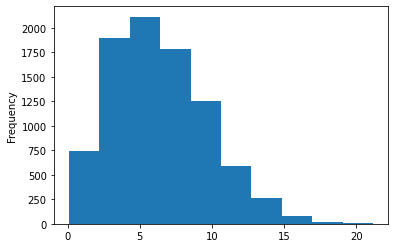

In [316]:
df_new.Wind_Spd.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

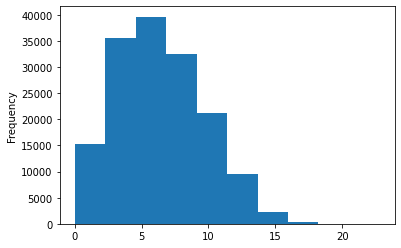

In [317]:
df1.Wind_Spd.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

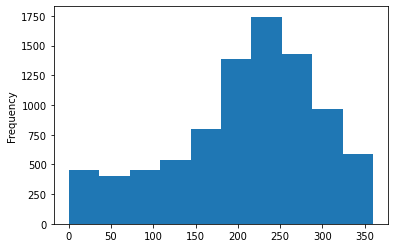

In [318]:
df_new.Wind_Dir.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

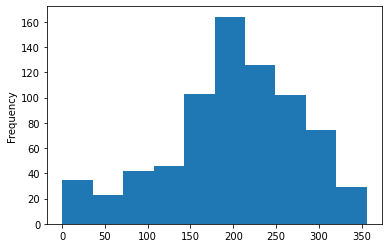

In [319]:
df_new.loc[df_new.index.month==7, 'Wind_Dir'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

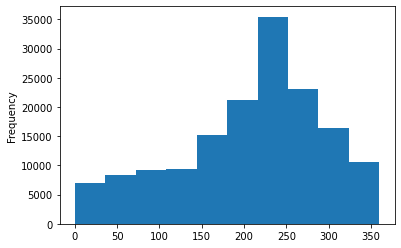

In [320]:
df1.Wind_Dir.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

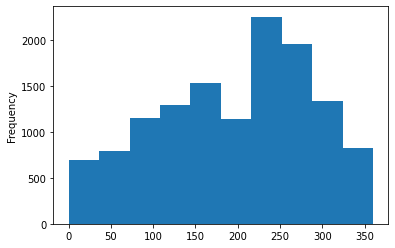

In [321]:
df1.loc[df1.index.month==7, 'Wind_Dir'].plot(kind='hist')

<AxesSubplot:>

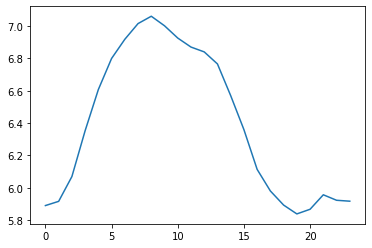

In [322]:
df_new.Wind_Spd.groupby(df_new.index.hour).mean().plot()

<AxesSubplot:xlabel='Date_Time'>

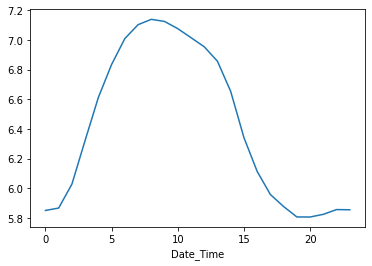

In [323]:
df.Wind_Spd.groupby(df.index.hour).mean().plot()

<AxesSubplot:>

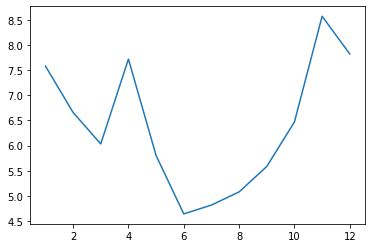

In [324]:
df_new.Wind_Spd.groupby(df_new.index.month).mean().plot()

<AxesSubplot:xlabel='Date_Time'>

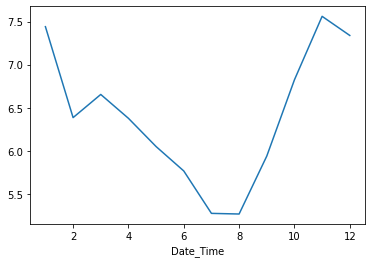

In [325]:
df.Wind_Spd.groupby(df.index.month).mean().plot()

<AxesSubplot:xlabel='Date_Time'>

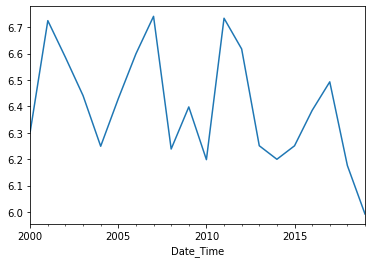

In [305]:
df.resample('YS').mean()['Wind_Spd'].plot()

c:\users\david.kyle\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1399: UserWarning: Attempting to set identical left == right == 40.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


<AxesSubplot:>

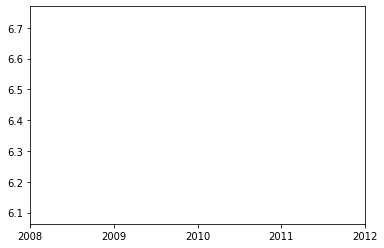

In [306]:
df_new.iloc[:-1,:].resample('YS').mean()['Wind_Spd'].plot()

<AxesSubplot:xlabel='Date_Time'>

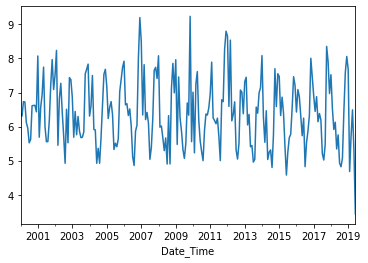

In [307]:
df.resample('MS').mean()['Wind_Spd'].plot()

<AxesSubplot:>

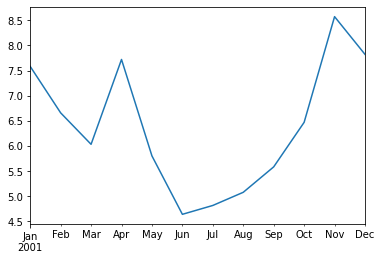

In [326]:
df_new.resample('MS').mean()['Wind_Spd'].plot()

In [328]:
df_export = df_new[['Wind_Spd', 'Wind_Dir']].copy()
# df_export = df_export.loc['2000-01-01 07:00:00':'2019-06-01 06:00:00']
df_export['Wind_Dir'] = df_export['Wind_Dir'].map(lambda x: '%.0f' % x)
df_export.index.name = 'Date_Time'
df_export.to_csv('ERA_modeled_2001.txt', sep='\t', float_format='%.3f')

In [329]:
df_export.head()

,Wind_Spd,Wind_Dir
Date_Time,,
2001-01-01 00:00:00,4.812381,236
2001-01-01 01:00:00,5.374148,235
2001-01-01 02:00:00,6.255794,232
2001-01-01 03:00:00,6.845308,230
2001-01-01 04:00:00,7.200541,236


In [327]:
df_orig_export = df.copy()
df_orig_export['Wind_Dir'] = df_orig_export['Wind_Dir'].map(lambda x: '%.0f' % x)
df_orig_export.loc['2001-01-01':'2001-12-31 23:00:00', ['Wind_Spd', 'Wind_Dir']].to_csv('ERA_original_2001.txt', sep='\t', float_format='%.3f')

In [331]:
df_orig_export.loc['2001-01-01':'2001-12-31 23:00:00', ['Wind_Spd', 'Wind_Dir']]

,Wind_Spd,Wind_Dir
Date_Time,,
2001-01-01 00:00:00,6.92,194
2001-01-01 01:00:00,7.69,199
2001-01-01 02:00:00,8.17,201
2001-01-01 03:00:00,8.20,203
2001-01-01 04:00:00,8.17,205
...,...,...
2001-12-31 19:00:00,0.11,26
2001-12-31 20:00:00,0.09,5
2001-12-31 21:00:00,0.46,34
